In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib # Necesario para guardar/cargar objetos
import pickle
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# Recuperar el mismo DataFrame
with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)
dfa = dfe.copy()

In [3]:
dfa = dfa.drop(['goles_local', 'goles_visitante'], axis=1)

In [4]:
# Ver las primeras filas del dataset
print(dfa.head())

# Ver las columnas disponibles
print("Columnas del dataset:")
print(dfa.columns.tolist())

   torneo  semestre    ronda  fecha_torneo equipo_local equipo_visitante  \
0    2021         1  INICIAL             1  millonarios         envigado   
1    2021         1  INICIAL             1       junior         medellin   
2    2021         1  INICIAL             1        pasto          equidad   
3    2021         1  INICIAL             1     nacional         santa fe   
4    2021         1  INICIAL             1         cali         jaguares   

  resultado  
0     LOCAL  
1     LOCAL  
2    EMPATE  
3     LOCAL  
4     LOCAL  
Columnas del dataset:
['torneo', 'semestre', 'ronda', 'fecha_torneo', 'equipo_local', 'equipo_visitante', 'resultado']


In [5]:
# Codificación categórica (LabelEncoder)
label_cols = ['ronda', 'equipo_local', 'equipo_visitante']
le_dict = {}

for col in label_cols:
    le = LabelEncoder()
    dfa[col] = le.fit_transform(dfa[col])
    le_dict[col] = le

label_resultado = LabelEncoder()
dfa['resultado'] = label_resultado.fit_transform(dfa['resultado'])

In [6]:
# Separar datos y etiquetas
X = dfa.drop("resultado", axis=1)
y = dfa["resultado"]

# Pesos balanceados por clase
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y),
                                     y=y)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
# VALIDACIÓN CRUZADA CON AJUSTE DE PARÁMETROS

# Configuración de la validación cruzada
kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42) 
accuracies = []
f1_scores = []
last_y_test = None
last_y_pred = None
fold_counter = 1


------INICIANDO VALIDACIÓN CRUZADA--------
-> Fold 1 completado. Acc: 0.3967
-> Fold 2 completado. Acc: 0.3160
-> Fold 3 completado. Acc: 0.3995
-> Fold 4 completado. Acc: 0.3885
-> Fold 5 completado. Acc: 0.3598
-> Fold 6 completado. Acc: 0.3475

----RESULTADO VALIDACIÓN CRUZADA-----
--------------------------------
Accuracy Promedio: 0.3680 (±0.0301)
F1-score Promedio: 0.3282 (±0.0178)
Todos los Accuracies: [0.3967168262653899, 0.31600547195622436, 0.399452804377565, 0.38850889192886456, 0.359781121751026, 0.34746922024623805]


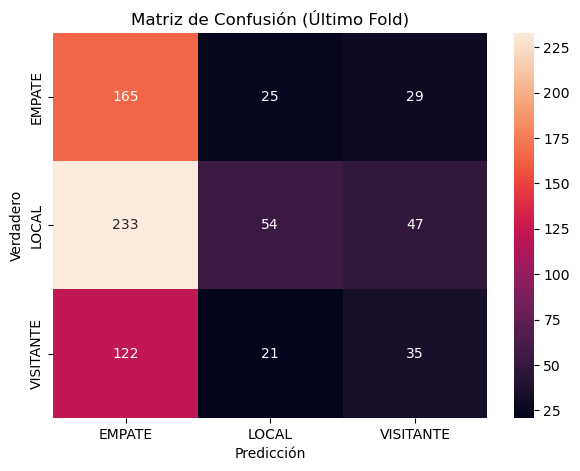

In [8]:
# Inicializar el Scaler fuera del bucle solo para el modelo final, pero lo entrenaremos por fold
scaler = StandardScaler()

print("\n------INICIANDO VALIDACIÓN CRUZADA--------")

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenar el scaler solo con los datos de entrenamiento
    X_train_scaled = scaler.fit_transform(X_train)
    # Aplicar la transformación a los datos de prueba
    X_test_scaled = scaler.transform(X_test)


    # Ajuste parametros dataset pequeño
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2), # Ajuste
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2), # Ajuste
        Dense(len(np.unique(y)), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Configuramos la paciencia de EarlyStopping a 10
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenar con datos escalados
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=4, 
              validation_data=(X_test_scaled, y_test),
              class_weight=class_weights_dict,
              verbose=0, callbacks=[es])

    # Predicción con datos escalados
    y_pred_probs = model.predict(X_test_scaled, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    last_y_test = y_test
    last_y_pred = y_pred
    
    print(f"-> Fold {fold_counter} completado. Acc: {accuracies[-1]:.4f}")
    fold_counter += 1


# === Resultados de la Validación Cruzada ===
print("\n----RESULTADO VALIDACIÓN CRUZADA-----")
print("--------------------------------")
print(f"Accuracy Promedio: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
print(f"F1-score Promedio: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")
print(f"Todos los Accuracies: {accuracies}")

# === Matriz de Confusión final (último fold) ===
if last_y_test is not None:
    cm = confusion_matrix(last_y_test, last_y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_resultado.classes_,
                yticklabels=label_resultado.classes_)
    plt.title("Matriz de Confusión (Último Fold)")
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.show()

In [9]:
# ENTRENAMIENTO DEL MODELO FINAL Y GUARDADO

print("\n\n=== ENTRENANDO MODELO FINAL Y GUARDANDO ARTEFACTOS ===")

# Entrenar el scaler con TODOS los datos para el modelo final
X_scaled_final = scaler.fit_transform(X)

# Recrear el modelo final con los parámetros ajustados
model_final = Sequential([
    Input(shape=(X_scaled_final.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='softmax')
])

model_final.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Entrenar el modelo final con todos los datos escalados
model_final.fit(X_scaled_final, y, epochs=50, batch_size=4, 
                class_weight=class_weights_dict, verbose=1)

# Guardar todos los artefactos necesarios
joblib.dump(le_dict, "encoders.pkl")
joblib.dump(label_resultado, "resultado_encoder.pkl")
joblib.dump(scaler, "scaler.pkl") # Guardar el scaler
model_final.save("modelo_partidos_ajustado.keras")
print("\n---Archivos guardados: encoders.pkl, resultado_encoder.pkl, scaler.pkl, modelo_partidos_ajustado.keras")



=== ENTRENANDO MODELO FINAL Y GUARDANDO ARTEFACTOS ===
Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3274 - loss: 1.3293
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3315 - loss: 1.1997
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3762 - loss: 1.1453
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3434 - loss: 1.1208
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3247 - loss: 1.1083
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3425 - loss: 1.1030
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3251 - loss: 1.1005
Epoch 8/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3529 - loss: 1.1003
Epoch 9/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3470 - loss: 1.0995
Epoch 10/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3821 - loss: 1.0989
Epoch 11/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3301 - loss: 1.

In [10]:
# Cargar modelo y encoders
modelo_cargado = load_model("modelo_partidos_ajustado.keras")
le_dict_cargado = joblib.load("encoders.pkl")
label_resultado_cargado = joblib.load("resultado_encoder.pkl")
scaler_cargado = joblib.load("scaler.pkl") # Cargar el scaler

def predecir_resultado(torneo, semestre, ronda, fecha, local, visitante):

    try:
        # Codificación categórica
        ronda_code = le_dict_cargado['ronda'].transform([ronda])[0]
        local_code = le_dict_cargado['equipo_local'].transform([local.lower()])[0]
        visitante_code = le_dict_cargado['equipo_visitante'].transform([visitante.lower()])[0]
    except Exception as e:
        return f"--Error: Equipo ('{local.title()}' o '{visitante.title()}') o ronda ('{ronda}') no existe en el dataset de entrenamiento. Detalle: {e}"

    entrada = pd.DataFrame([[torneo, semestre, ronda_code, fecha,
                             local_code, visitante_code]],
                           columns=X.columns)

    # Estandarizar la entrada
    entrada_scaled = scaler_cargado.transform(entrada)
    
    # Predicción
    pred = modelo_cargado.predict(entrada_scaled, verbose=0)
    pred_clase = np.argmax(pred)

    # Decodificar y formatear salida
    resultado_texto = label_resultado_cargado.inverse_transform([pred_clase])[0]
    mapa_emoji = {
        "LOCAL": "Gana el Local",
        "EMPATE": "Empate",
        "VISITANTE": "Gana el Visitante"
    }

    resultado_final = mapa_emoji.get(resultado_texto, resultado_texto)

    print("\n\n-----Predicción del Modelo MLP-----)")
    print("--------------------------------------")
    print(f"Partido: {local.title()} vs {visitante.title()}")
    print(f"Resultado probable: {resultado_final}")
    print(f"Porcentaje: {pred[0][pred_clase] * 100:.2f}%")

    return resultado_final

In [11]:
# Ejemplo de uso
predecir_resultado(
    torneo=2025,
    semestre=2,
    ronda="INICIAL",
    fecha=15,
    local="tolima",
    visitante="junior"
)



-----Predicción del Modelo MLP-----)
--------------------------------------
Partido: Tolima vs Junior
Resultado probable: Gana el Visitante
Porcentaje: 34.16%


'Gana el Visitante'